In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import linkage, fcluster, cophenet, dendrogram
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
import warnings
import os
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

In [2]:
DATA_DIR = "data"
OUT_DIR = "output/Phase_3"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
MATRIX_PATH = os.path.join(DATA_DIR, "GSE54564_series_matrix.txt")
ANNOTATION_PATH = os.path.join(DATA_DIR, "NCBI_Depression.bgx")


print("Loading expression matrix...")
matrix_data = pd.read_csv(MATRIX_PATH, sep="\t", comment="!", index_col=0)

labels = []
with open(MATRIX_PATH, 'r') as f:
    for line in f:
        if "disease state" in line.lower():
            labels = line.strip().split("\t")[1:]
            break

y = (pd.Series(labels, index=matrix_data.columns)
     .str.replace('"', '').str.replace('disease state:', "").str.strip()
     .map({"MDD case": 1, "Control": 0}))

print("Loading gene annotations...")
with open(ANNOTATION_PATH, 'r') as f:
    lines = f.readlines()
start = next(i+1 for i, line in enumerate(lines) if line.strip() == "[Probes]")
bgx = pd.read_csv(ANNOTATION_PATH, sep="\t", skiprows=start, engine="python")

probe_col = 'Probe_Id' if 'Probe_Id' in bgx.columns else 'Name'
probe_to_gene = dict(zip(bgx[probe_col], bgx['Symbol']))

gene_names, valid_probes = [], []
for probe in matrix_data.index:
    if probe in probe_to_gene and pd.notna(probe_to_gene[probe]):
        gene = str(probe_to_gene[probe]).strip()
        if gene:
            gene_names.append(gene)
            valid_probes.append(probe)

X_raw = matrix_data.loc[valid_probes].T.values
sample_ids = matrix_data.columns.tolist()

if np.max(X_raw) > 100:
    X_raw = np.log2(X_raw + 1)

X = stats.zscore(X_raw, axis=0)
X = np.nan_to_num(X, nan=0.0)
y = y.values

print(f"Loaded: {X.shape[0]} samples x {X.shape[1]:,} genes")
print(f"MDD: {sum(y==1)}, Control: {sum(y==0)}")

Loading expression matrix...
Loading gene annotations...
Loaded: 42 samples x 36,157 genes
MDD: 21, Control: 21


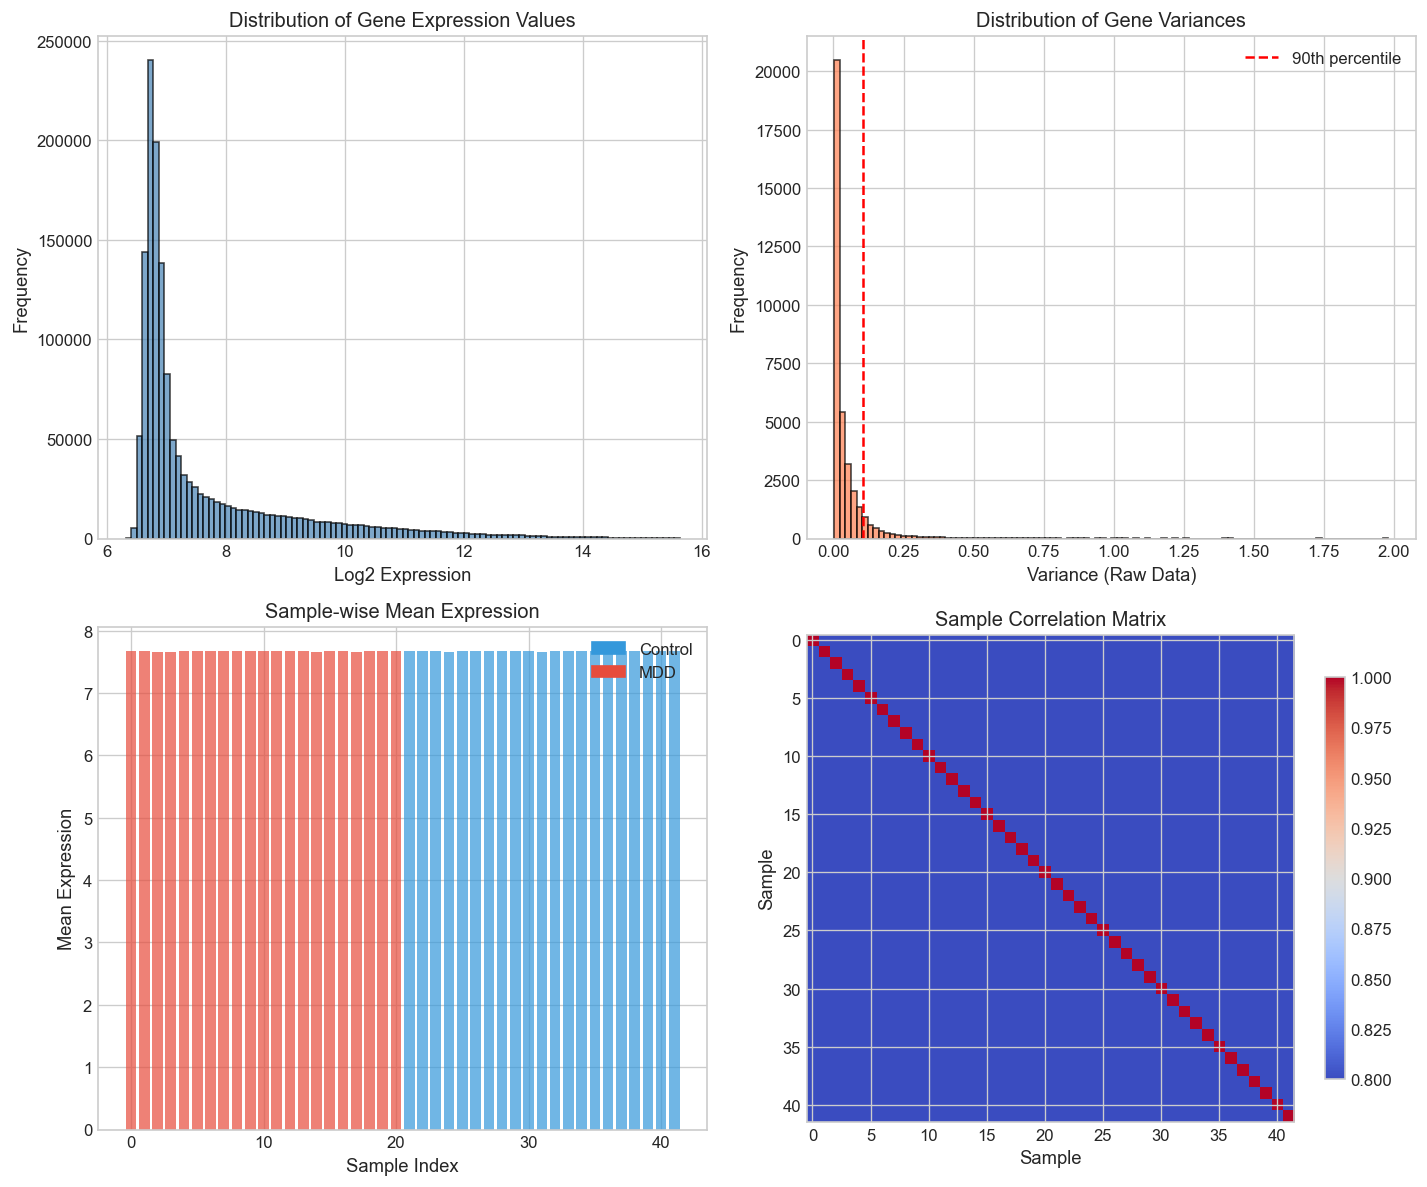

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Expression distribution
ax1 = axes[0, 0]
ax1.hist(X_raw.flatten(), bins=100, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Log2 Expression')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Gene Expression Values')

# Gene variance distribution - USE X_RAW INSTEAD
ax2 = axes[0, 1]
gene_vars = np.var(X_raw, axis=0)  # Use raw data, not standardized
ax2.hist(gene_vars, bins=100, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(np.percentile(gene_vars, 90), color='red', linestyle='--', label='90th percentile')
ax2.set_xlabel('Variance (Raw Data)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Gene Variances')
ax2.legend()

# Sample-wise mean expression
ax3 = axes[1, 0]
sample_means = np.mean(X_raw, axis=1)
colors = ['#e74c3c' if yi == 1 else '#3498db' for yi in y]
ax3.bar(range(len(sample_means)), sample_means, color=colors, alpha=0.7)
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Mean Expression')
ax3.set_title('Sample-wise Mean Expression')
ax3.legend(handles=[Patch(color='#3498db', label='Control'), Patch(color='#e74c3c', label='MDD')])

# Sample correlation heatmap
ax4 = axes[1, 1]
sample_corr = np.corrcoef(X)
im = ax4.imshow(sample_corr, cmap='coolwarm', vmin=0.8, vmax=1.0)
ax4.set_title('Sample Correlation Matrix')
ax4.set_xlabel('Sample')
ax4.set_ylabel('Sample')
plt.colorbar(im, ax=ax4, shrink=0.8)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'Figure0_Basic EDA.png'), dpi=300, bbox_inches='tight')
plt.show()


In [5]:
print("="*60)
print("CONSENSUS CLUSTERING - SUBTYPE DISCOVERY")
print("="*60)

# Parameters
max_k = 5
n_iter = 500
subsample_frac = 0.8

# Select top variable genes
gene_vars = np.var(X, axis=0)
n_top_genes = 3000
top_idx = np.argsort(gene_vars)[-n_top_genes:]
X_filt = X[:, top_idx]
n_samples = X.shape[0]

print(f"Using top {n_top_genes} variable genes")
print(f"Running {n_iter} iterations with {subsample_frac*100:.0f}% subsampling")

consensus_results = {}

for k in range(2, max_k + 1):
    print(f"\nk = {k}...")
    
    consensus = np.zeros((n_samples, n_samples))
    counts = np.zeros((n_samples, n_samples))
    
    for it in tqdm(range(n_iter), desc=f"  k={k}"):
        idx = np.random.choice(n_samples, int(n_samples * subsample_frac), replace=False)
        X_sub = X_filt[idx]
        
        if it % 3 == 0:
            model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        elif it % 3 == 1:
            model = KMeans(n_clusters=k, n_init=10, random_state=it)
        else:
            model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                      n_neighbors=8, random_state=it)
        
        labels_sub = model.fit_predict(X_sub)
        
        for i in range(len(idx)):
            for j in range(i+1, len(idx)):
                ii, jj = idx[i], idx[j]
                counts[ii, jj] += 1
                counts[jj, ii] += 1
                if labels_sub[i] == labels_sub[j]:
                    consensus[ii, jj] += 1
                    consensus[jj, ii] += 1
    
    consensus = np.divide(consensus, counts, out=np.zeros_like(consensus), where=counts != 0)
    np.fill_diagonal(consensus, 1.0)
    
    dist = 1 - consensus
    np.fill_diagonal(dist, 0)
    dist = (dist + dist.T) / 2
    
    Z = linkage(squareform(dist), method='average')
    labels = fcluster(Z, k, criterion='maxclust') - 1
    
    coph, _ = cophenet(Z, squareform(dist))
    sil = silhouette_score(X_filt, labels)
    sil_samples = silhouette_samples(X_filt, labels)
    
    mask = np.triu(np.ones_like(consensus, dtype=bool), k=1)
    pac = np.mean((consensus[mask] > 0.1) & (consensus[mask] < 0.9))
    
    consensus_results[k] = {
        'consensus': consensus,
        'labels': labels,
        'linkage': Z,
        'cophenetic': coph,
        'silhouette': sil,
        'silhouette_samples': sil_samples,
        'pac': pac
    }
    
    print(f"  Cophenetic: {coph:.3f}, Silhouette: {sil:.3f}, PAC: {pac:.3f}")

# Determine optimal k
scores = {k: r['cophenetic'] - r['pac'] + r['silhouette'] for k, r in consensus_results.items()}
optimal_k = max(scores, key=scores.get)
subtype_labels = consensus_results[optimal_k]['labels']

print(f"\nOptimal k = {optimal_k} (by composite score)")

CONSENSUS CLUSTERING - SUBTYPE DISCOVERY
Using top 3000 variable genes
Running 500 iterations with 80% subsampling

k = 2...


  k=2:   0%|          | 0/500 [00:00<?, ?it/s]

  Cophenetic: 0.925, Silhouette: 0.128, PAC: 0.649

k = 3...


  k=3:   0%|          | 0/500 [00:00<?, ?it/s]

  Cophenetic: 0.967, Silhouette: 0.058, PAC: 0.387

k = 4...


  k=4:   0%|          | 0/500 [00:00<?, ?it/s]

  Cophenetic: 0.968, Silhouette: 0.052, PAC: 0.336

k = 5...


  k=5:   0%|          | 0/500 [00:00<?, ?it/s]

  Cophenetic: 0.959, Silhouette: 0.050, PAC: 0.379

Optimal k = 4 (by composite score)


In [6]:
print("="*60)
print(f"SUBTYPE ANALYSIS (k={optimal_k})")
print("="*60)

print("\nSubtype Composition:")
subtype_info = []
for s in range(optimal_k):
    mask = subtype_labels == s
    n_total = sum(mask)
    n_mdd = sum(y[mask] == 1)
    n_ctrl = sum(y[mask] == 0)
    pct_mdd = n_mdd / n_total * 100 if n_total > 0 else 0
    
    subtype_info.append({
        'Subtype': s,
        'Total': n_total,
        'MDD': n_mdd,
        'Control': n_ctrl,
        'Pct_MDD': pct_mdd
    })
    print(f"  Subtype {s}: {n_total} samples (MDD={n_mdd} [{pct_mdd:.0f}%], Ctrl={n_ctrl})")

subtype_df = pd.DataFrame(subtype_info)

# Statistical tests
contingency = [[sum((subtype_labels == s) & (y == d)) for d in [0, 1]] for s in range(optimal_k)]
chi2, p_subtype, dof, expected = stats.chi2_contingency(contingency)
ari = adjusted_rand_score(y, subtype_labels)

print(f"\nStatistical Tests:")
print(f"  Chi-square statistic: {chi2:.3f}")
print(f"  Chi-square p-value: {p_subtype:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  Adjusted Rand Index: {ari:.3f}")

if p_subtype < 0.05:
    print("\n  Result: Subtypes significantly associated with diagnosis (p < 0.05)")
else:
    print("\n  Result: No significant association between subtypes and diagnosis")

SUBTYPE ANALYSIS (k=4)

Subtype Composition:
  Subtype 0: 8 samples (MDD=4 [50%], Ctrl=4)
  Subtype 1: 9 samples (MDD=4 [44%], Ctrl=5)
  Subtype 2: 18 samples (MDD=7 [39%], Ctrl=11)
  Subtype 3: 7 samples (MDD=6 [86%], Ctrl=1)

Statistical Tests:
  Chi-square statistic: 4.571
  Chi-square p-value: 0.2060
  Degrees of freedom: 3
  Adjusted Rand Index: 0.014

  Result: No significant association between subtypes and diagnosis


In [7]:
CELL_MARKERS = {
    'Neurons_Pan': ['SNAP25', 'SYT1', 'RBFOX3', 'MAP2', 'ENO2', 'SYN1', 'SYP', 'NRGN', 'NEFL'],
    'Neurons_Excit': ['SLC17A7', 'SLC17A6', 'GRIN1', 'GRIN2A', 'GRIN2B', 'CAMK2A'],
    'Neurons_Inhib': ['GAD1', 'GAD2', 'SLC32A1', 'PVALB', 'SST', 'VIP', 'NPY'],
    'Astrocytes': ['GFAP', 'AQP4', 'ALDH1L1', 'SLC1A2', 'SLC1A3', 'S100B', 'GLUL'],
    'Microglia': ['AIF1', 'CD68', 'ITGAM', 'CX3CR1', 'P2RY12', 'TMEM119', 'TREM2'],
    'Oligodendro': ['MBP', 'MOG', 'PLP1', 'MAG', 'CNP', 'OLIG1', 'OLIG2'],
    'Endothelial': ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']
}

print("Cell-Type Marker Panels:")
print("-" * 40)
for ct, markers in CELL_MARKERS.items():
    print(f"{ct}: {len(markers)} markers")
    print(f"  {', '.join(markers)}")

Cell-Type Marker Panels:
----------------------------------------
Neurons_Pan: 9 markers
  SNAP25, SYT1, RBFOX3, MAP2, ENO2, SYN1, SYP, NRGN, NEFL
Neurons_Excit: 6 markers
  SLC17A7, SLC17A6, GRIN1, GRIN2A, GRIN2B, CAMK2A
Neurons_Inhib: 7 markers
  GAD1, GAD2, SLC32A1, PVALB, SST, VIP, NPY
Astrocytes: 7 markers
  GFAP, AQP4, ALDH1L1, SLC1A2, SLC1A3, S100B, GLUL
Microglia: 7 markers
  AIF1, CD68, ITGAM, CX3CR1, P2RY12, TMEM119, TREM2
Oligodendro: 7 markers
  MBP, MOG, PLP1, MAG, CNP, OLIG1, OLIG2
Endothelial: 5 markers
  PECAM1, VWF, CDH5, CLDN5, FLT1


In [8]:
print("="*60)
print("CELL-TYPE DECONVOLUTION")
print("="*60)

gene_to_idx = {g.upper(): i for i, g in enumerate(gene_names)}
celltype_scores = {}

print("\nMarker Coverage:")
marker_coverage = []
for ct, markers in CELL_MARKERS.items():
    found = [m for m in markers if m.upper() in gene_to_idx]
    idx = [gene_to_idx[m.upper()] for m in found]
    coverage = len(found) / len(markers) * 100
    marker_coverage.append({'Cell_Type': ct, 'Found': len(found), 'Total': len(markers), 'Coverage': coverage})
    print(f"  {ct}: {len(found)}/{len(markers)} ({coverage:.0f}%)")
    if len(idx) >= 3:
        celltype_scores[ct] = np.mean(X[:, idx], axis=1)

celltype_df = pd.DataFrame(celltype_scores)

print("\n" + "-"*60)
print("MDD vs Control Comparison:")
print("-"*60)

celltype_results = []
for ct in celltype_df.columns:
    ctrl = celltype_df.loc[y == 0, ct].values
    mdd = celltype_df.loc[y == 1, ct].values
    
    t_stat, p_val = stats.ttest_ind(mdd, ctrl)
    u_stat, p_mwu = stats.mannwhitneyu(mdd, ctrl, alternative='two-sided')
    
    pooled = np.sqrt(((len(ctrl)-1)*np.var(ctrl, ddof=1) + (len(mdd)-1)*np.var(mdd, ddof=1)) / (len(ctrl)+len(mdd)-2))
    cohens_d = (np.mean(mdd) - np.mean(ctrl)) / pooled if pooled > 0 else 0
    
    celltype_results.append({
        'cell_type': ct,
        'mean_ctrl': np.mean(ctrl),
        'mean_mdd': np.mean(mdd),
        'std_ctrl': np.std(ctrl),
        'std_mdd': np.std(mdd),
        't_statistic': t_stat,
        'p_value': p_val,
        'p_mwu': p_mwu,
        'cohens_d': cohens_d
    })
    
    sig = '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
    direction = 'increased' if cohens_d > 0 else 'decreased'
    print(f"  {ct}: d={cohens_d:.2f} ({direction} in MDD), p={p_val:.4f} {sig}")

celltype_results_df = pd.DataFrame(celltype_results)

n_sig = sum(r['p_value'] < 0.05 for r in celltype_results)
print(f"\nSignificant cell types (p < 0.05): {n_sig}/{len(celltype_results)}")

CELL-TYPE DECONVOLUTION

Marker Coverage:
  Neurons_Pan: 8/9 (89%)
  Neurons_Excit: 6/6 (100%)
  Neurons_Inhib: 7/7 (100%)
  Astrocytes: 7/7 (100%)
  Microglia: 7/7 (100%)
  Oligodendro: 7/7 (100%)
  Endothelial: 5/5 (100%)

------------------------------------------------------------
MDD vs Control Comparison:
------------------------------------------------------------
  Neurons_Pan: d=-0.22 (decreased in MDD), p=0.4783 
  Neurons_Excit: d=0.21 (increased in MDD), p=0.5060 
  Neurons_Inhib: d=-0.77 (decreased in MDD), p=0.0163 *
  Astrocytes: d=0.47 (increased in MDD), p=0.1345 
  Microglia: d=-0.63 (decreased in MDD), p=0.0463 *
  Oligodendro: d=0.64 (increased in MDD), p=0.0441 *
  Endothelial: d=0.78 (increased in MDD), p=0.0156 *

Significant cell types (p < 0.05): 4/7


In [9]:
print("="*60)
print("NETWORK ANALYSIS (WGCNA-style)")
print("="*60)

# Parameters
n_genes_net = 4000
soft_power = 6
min_module_size = 30
n_modules_cut = 8

gene_vars = np.var(X, axis=0)
top_idx_net = np.argsort(gene_vars)[-n_genes_net:]
X_net = X[:, top_idx_net]
genes_net = [gene_names[i] for i in top_idx_net]

print(f"Building network with {n_genes_net} genes...")
print(f"Soft threshold power: {soft_power}")

# Correlation and adjacency
print("Computing correlation matrix...")
corr = np.corrcoef(X_net.T)

print("Applying soft threshold...")
adj = np.abs(corr) ** soft_power
np.fill_diagonal(adj, 0)

# Connectivity
connectivity = np.sum(adj, axis=1)

# Distance matrix
dist_net = 1 - adj
np.fill_diagonal(dist_net, 0)
dist_net = (dist_net + dist_net.T) / 2

# Hierarchical clustering
print("Clustering genes...")
Z_net = linkage(squareform(dist_net), method='average')
module_labels = fcluster(Z_net, n_modules_cut, criterion='maxclust')

# Filter valid modules
counts = Counter(module_labels)
valid_mods = [m for m, c in counts.items() if c >= min_module_size]
print(f"Found {len(valid_mods)} modules with >= {min_module_size} genes")

# Extract module information
modules = {}
eigengenes = np.zeros((X.shape[0], len(valid_mods)))

print("\nModule Summary:")
print("-" * 60)

for i, m in enumerate(sorted(valid_mods)):
    mask = module_labels == m
    mod_genes = [genes_net[j] for j in np.where(mask)[0]]
    mod_idx = top_idx_net[mask]
    
    mod_expr = X[:, mod_idx]
    pca = PCA(n_components=1)
    eg = pca.fit_transform(mod_expr - mod_expr.mean(axis=0)).flatten()
    
    if np.corrcoef(eg, mod_expr.mean(axis=1))[0, 1] < 0:
        eg = -eg
    
    mod_conn = connectivity[mask]
    hub_idx = np.argsort(mod_conn)[-5:][::-1]
    hubs = [mod_genes[j] for j in hub_idx]
    
    modules[f'M{i+1}'] = {
        'genes': mod_genes,
        'size': len(mod_genes),
        'hubs': hubs,
        'mean_connectivity': np.mean(mod_conn)
    }
    eigengenes[:, i] = eg
    
    print(f"  M{i+1}: {len(mod_genes)} genes")
    print(f"       Hub genes: {', '.join(hubs)}")

NETWORK ANALYSIS (WGCNA-style)
Building network with 4000 genes...
Soft threshold power: 6
Computing correlation matrix...
Applying soft threshold...
Clustering genes...
Found 8 modules with >= 30 genes

Module Summary:
------------------------------------------------------------
  M1: 96 genes
       Hub genes: DNAHL1, C9orf9, HIST1H4D, LOC643720, LOC158830
  M2: 39 genes
       Hub genes: MED8, ZBTB41, LOC645349, LOC650034, KIAA0565
  M3: 88 genes
       Hub genes: VCX3A, KHDRBS2, ATP13A1, MATK, PURG
  M4: 101 genes
       Hub genes: LOC652492, RPS29, PPP1CA, BCAS4, LOC391276
  M5: 43 genes
       Hub genes: GRM7, CCNYL1, LOC653464, LOC648454, NPR3
  M6: 120 genes
       Hub genes: AVIL, GABRE, ZNF460, LRRC48, PRH1
  M7: 104 genes
       Hub genes: CECR2, ARHGAP25, KCNC4, AMY2B, GRIN1
  M8: 3409 genes
       Hub genes: GLRB, SERPINI1, MDH1, ITFG1, DCLK1


In [10]:
print("="*60)
print("MODULE-TRAIT CORRELATIONS")
print("="*60)

print("\nCorrelation with Diagnosis (MDD=1, Control=0):")
print("-" * 50)

module_traits = []
for i, (name, info) in enumerate(modules.items()):
    corr_val, p_val = stats.pointbiserialr(y, eigengenes[:, i])
    
    module_traits.append({
        'module': name,
        'correlation': corr_val,
        'p_value': p_val,
        'n_genes': info['size']
    })
    
    sig = '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
    direction = 'up in MDD' if corr_val > 0 else 'down in MDD'
    
    if p_val < 0.1:
        print(f"  {name}: r = {corr_val:.3f}, p = {p_val:.4f} {sig} ({direction})")
    else:
        print(f"  {name}: r = {corr_val:.3f}, p = {p_val:.4f}")

module_traits_df = pd.DataFrame(module_traits)

# Correlation with subtypes
print("\nCorrelation with Subtypes:")
print("-" * 50)

for s in range(optimal_k):
    subtype_binary = (subtype_labels == s).astype(int)
    sig_mods = []
    for i, (name, info) in enumerate(modules.items()):
        corr_val, p_val = stats.pointbiserialr(subtype_binary, eigengenes[:, i])
        if p_val < 0.1:
            sig_mods.append((name, corr_val, p_val))
    
    if sig_mods:
        print(f"  Subtype {s}:")
        for name, corr_val, p_val in sig_mods:
            sig = '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            print(f"    {name}: r = {corr_val:.3f}, p = {p_val:.4f} {sig}")

MODULE-TRAIT CORRELATIONS

Correlation with Diagnosis (MDD=1, Control=0):
--------------------------------------------------
  M1: r = -0.129, p = 0.4160
  M2: r = 0.192, p = 0.2223
  M3: r = 0.175, p = 0.2669
  M4: r = 0.001, p = 0.9958
  M5: r = -0.181, p = 0.2508
  M6: r = 0.096, p = 0.5435
  M7: r = -0.095, p = 0.5501
  M8: r = -0.291, p = 0.0618  (down in MDD)

Correlation with Subtypes:
--------------------------------------------------
  Subtype 2:
    M7: r = 0.289, p = 0.0638 
    M8: r = 0.302, p = 0.0520 
  Subtype 3:
    M8: r = -0.842, p = 0.0000 **


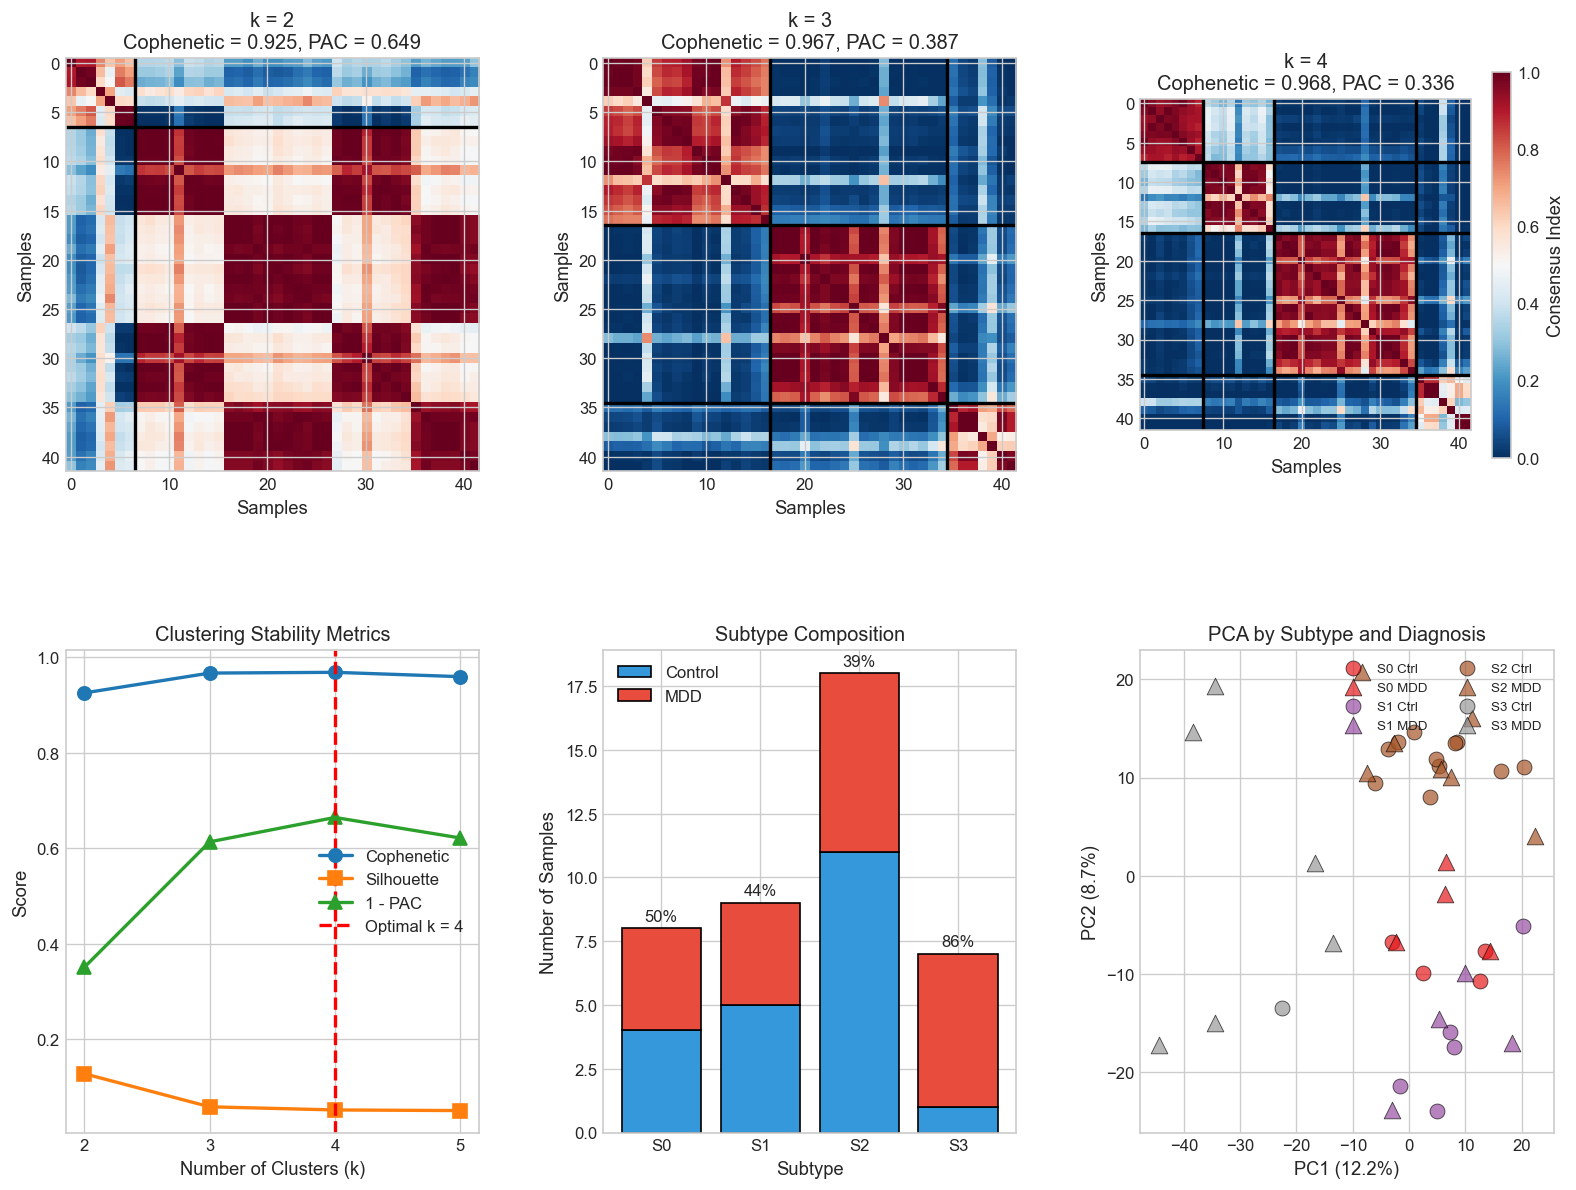

In [11]:
fig1 = plt.figure(figsize=(16, 12))
gs1 = gridspec.GridSpec(2, 3, figure=fig1, hspace=0.3, wspace=0.3)

# Row 1: Consensus heatmaps for k=2, 3, 4
for idx, k in enumerate([2, 3, 4]):
    if k not in consensus_results:
        continue
    ax = fig1.add_subplot(gs1[0, idx])
    cons = consensus_results[k]['consensus']
    labels_k = consensus_results[k]['labels']
    
    sort_idx = np.lexsort((y, labels_k))
    cons_sorted = cons[sort_idx][:, sort_idx]
    
    im = ax.imshow(cons_sorted, cmap='RdBu_r', vmin=0, vmax=1)
    
    sizes = [sum(labels_k[sort_idx] == c) for c in range(k)]
    for b in np.cumsum(sizes)[:-1]:
        ax.axhline(b - 0.5, color='black', linewidth=2)
        ax.axvline(b - 0.5, color='black', linewidth=2)
    
    coph = consensus_results[k]['cophenetic']
    pac = consensus_results[k]['pac']
    ax.set_title(f'k = {k}\nCophenetic = {coph:.3f}, PAC = {pac:.3f}')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Samples')
    
    if idx == 2:
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('Consensus Index')

# Row 2, Col 1: Stability metrics by k
ax_b = fig1.add_subplot(gs1[1, 0])
ks = sorted(consensus_results.keys())
cophs = [consensus_results[k]['cophenetic'] for k in ks]
sils = [consensus_results[k]['silhouette'] for k in ks]
pacs = [1 - consensus_results[k]['pac'] for k in ks]

ax_b.plot(ks, cophs, 'o-', label='Cophenetic', linewidth=2, markersize=8)
ax_b.plot(ks, sils, 's-', label='Silhouette', linewidth=2, markersize=8)
ax_b.plot(ks, pacs, '^-', label='1 - PAC', linewidth=2, markersize=8)
ax_b.axvline(optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal k = {optimal_k}')

ax_b.set_xlabel('Number of Clusters (k)')
ax_b.set_ylabel('Score')
ax_b.set_title('Clustering Stability Metrics')
ax_b.legend(loc='best')
ax_b.set_xticks(ks)

# Row 2, Col 2: Subtype composition
ax_c = fig1.add_subplot(gs1[1, 1])
ctrl_n = [sum((subtype_labels == s) & (y == 0)) for s in range(optimal_k)]
mdd_n = [sum((subtype_labels == s) & (y == 1)) for s in range(optimal_k)]

x_pos = np.arange(optimal_k)
ax_c.bar(x_pos, ctrl_n, label='Control', color='#3498db', edgecolor='black')
ax_c.bar(x_pos, mdd_n, bottom=ctrl_n, label='MDD', color='#e74c3c', edgecolor='black')

for i in range(optimal_k):
    total = ctrl_n[i] + mdd_n[i]
    pct = mdd_n[i] / total * 100 if total > 0 else 0
    ax_c.text(i, total + 0.3, f'{pct:.0f}%', ha='center', fontsize=10)

ax_c.set_xlabel('Subtype')
ax_c.set_ylabel('Number of Samples')
ax_c.set_title('Subtype Composition')
ax_c.set_xticks(x_pos)
ax_c.set_xticklabels([f'S{s}' for s in range(optimal_k)])
ax_c.legend()

# Row 2, Col 3: PCA by subtype
ax_d = fig1.add_subplot(gs1[1, 2])
pca_vis = PCA(n_components=2)
X_pca = pca_vis.fit_transform(X[:, np.argsort(np.var(X, axis=0))[-2000:]])

colors_sub = plt.cm.Set1(np.linspace(0, 1, optimal_k))
for s in range(optimal_k):
    mask = subtype_labels == s
    ax_d.scatter(X_pca[mask & (y==0), 0], X_pca[mask & (y==0), 1],
                c=[colors_sub[s]], marker='o', s=80, alpha=0.7,
                edgecolors='black', linewidth=0.5, label=f'S{s} Ctrl')
    ax_d.scatter(X_pca[mask & (y==1), 0], X_pca[mask & (y==1), 1],
                c=[colors_sub[s]], marker='^', s=100, alpha=0.7,
                edgecolors='black', linewidth=0.5, label=f'S{s} MDD')

ax_d.set_xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]*100:.1f}%)')
ax_d.set_ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]*100:.1f}%)')
ax_d.set_title('PCA by Subtype and Diagnosis')
ax_d.legend(loc='upper right', fontsize=8, ncol=2)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'Figure1_Subtypes.png'), dpi=300, bbox_inches='tight')
plt.show()

Saved: Figure2_CellTypes.png


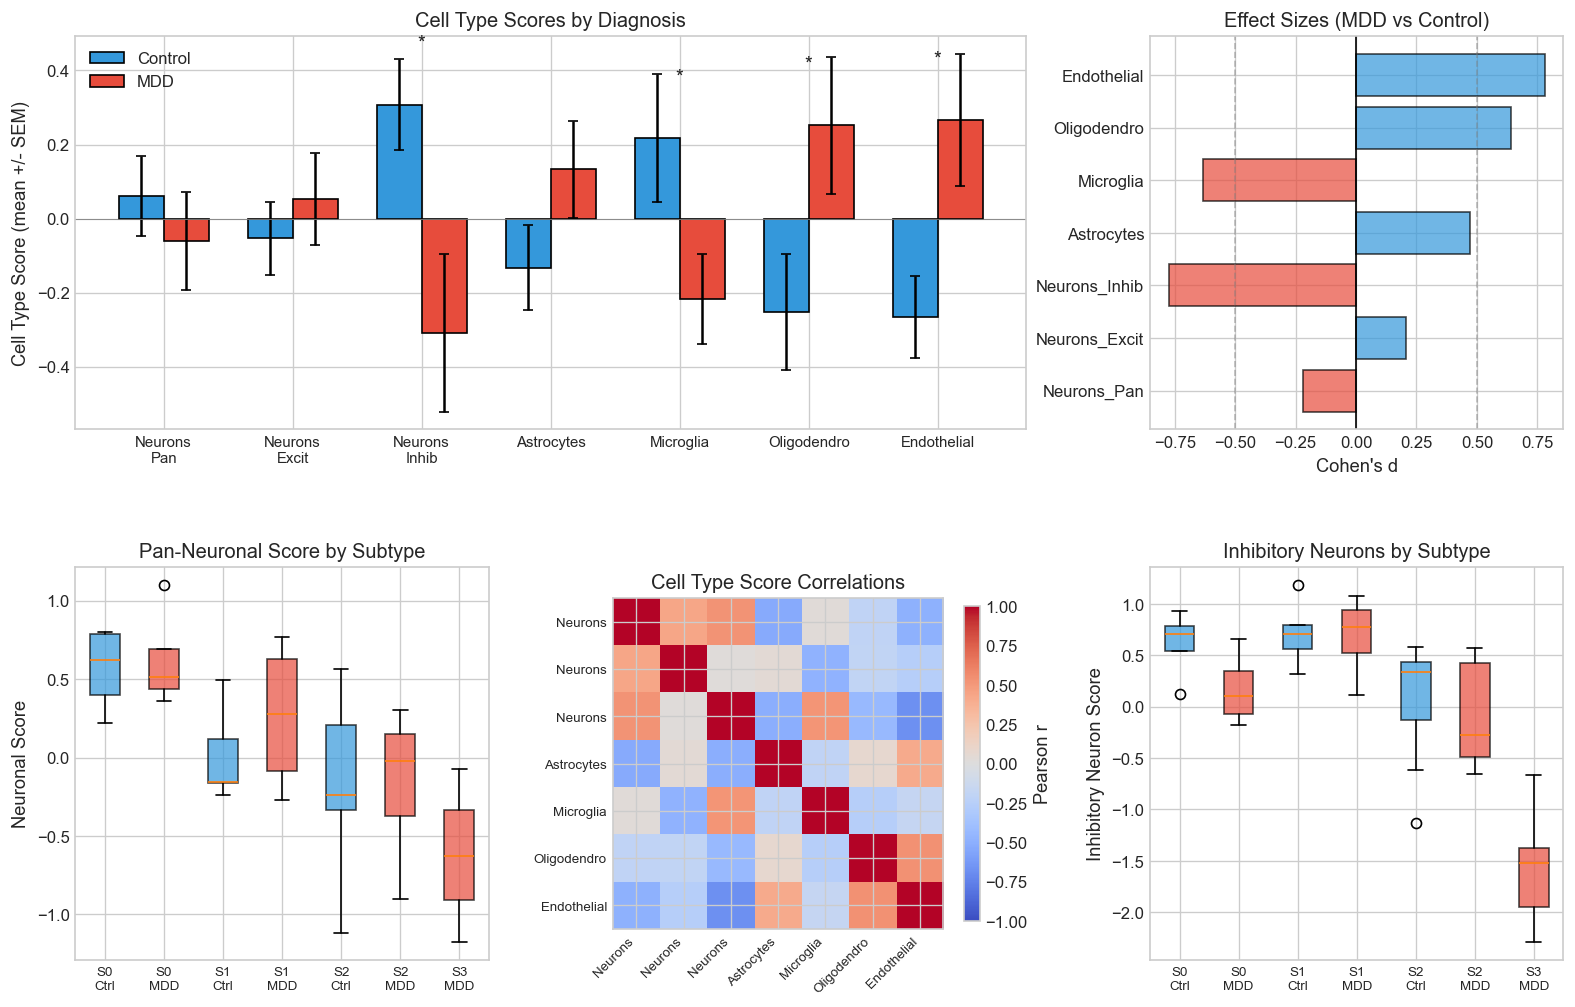

In [12]:
fig2 = plt.figure(figsize=(16, 10))
gs2 = gridspec.GridSpec(2, 3, figure=fig2, hspace=0.35, wspace=0.3)

ct_names = celltype_df.columns.tolist()

# Panel A: Cell type scores by diagnosis
ax2a = fig2.add_subplot(gs2[0, :2])
x_ct = np.arange(len(ct_names))
width = 0.35

ctrl_means = celltype_df[y == 0].mean()
ctrl_sems = celltype_df[y == 0].sem()
mdd_means = celltype_df[y == 1].mean()
mdd_sems = celltype_df[y == 1].sem()

ax2a.bar(x_ct - width/2, ctrl_means, width, yerr=ctrl_sems, label='Control',
         color='#3498db', edgecolor='black', capsize=3)
ax2a.bar(x_ct + width/2, mdd_means, width, yerr=mdd_sems, label='MDD',
         color='#e74c3c', edgecolor='black', capsize=3)

for i, ct in enumerate(ct_names):
    p_val = celltype_results_df.loc[celltype_results_df['cell_type'] == ct, 'p_value'].values[0]
    if p_val < 0.01:
        ax2a.text(i, max(ctrl_means[i], mdd_means[i]) + 0.15, '**', ha='center', fontsize=12)
    elif p_val < 0.05:
        ax2a.text(i, max(ctrl_means[i], mdd_means[i]) + 0.15, '*', ha='center', fontsize=12)

ax2a.set_xticks(x_ct)
ax2a.set_xticklabels([ct.replace('_', '\n') for ct in ct_names], fontsize=9)
ax2a.set_ylabel('Cell Type Score (mean +/- SEM)')
ax2a.set_title('Cell Type Scores by Diagnosis')
ax2a.legend()
ax2a.axhline(0, color='gray', linestyle='-', linewidth=0.5)

# Panel B: Effect sizes
ax2b = fig2.add_subplot(gs2[0, 2])
effect_sizes = [r['cohens_d'] for r in celltype_results]
colors_ef = ['#e74c3c' if d < 0 else '#3498db' for d in effect_sizes]

ax2b.barh(range(len(ct_names)), effect_sizes, color=colors_ef, alpha=0.7, edgecolor='black')
ax2b.axvline(0, color='black', linewidth=1)
ax2b.axvline(-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2b.axvline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax2b.set_yticks(range(len(ct_names)))
ax2b.set_yticklabels(ct_names)
ax2b.set_xlabel("Cohen's d")
ax2b.set_title('Effect Sizes (MDD vs Control)')

# Panel C: Neuronal score by subtype
ax2c = fig2.add_subplot(gs2[1, 0])
if 'Neurons_Pan' in celltype_df.columns:
    neur = celltype_df['Neurons_Pan'].values
    data_neur = []
    labels_neur = []
    colors_neur = []
    
    for s in np.unique(subtype_labels):
        for d in [0, 1]:
            mask = (subtype_labels == s) & (y == d)
            if sum(mask) >= 2:
                data_neur.append(neur[mask])
                labels_neur.append(f'S{s}\n{"MDD" if d else "Ctrl"}')
                colors_neur.append('#e74c3c' if d else '#3498db')
    
    bp = ax2c.boxplot(data_neur, patch_artist=True)
    for i, (patch, color) in enumerate(zip(bp['boxes'], colors_neur)):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2c.set_xticklabels(labels_neur, fontsize=8)
    ax2c.set_ylabel('Neuronal Score')
    ax2c.set_title('Pan-Neuronal Score by Subtype')

# Panel D: Cell type correlation matrix
ax2d = fig2.add_subplot(gs2[1, 1])
ct_corr = celltype_df.corr()

im2d = ax2d.imshow(ct_corr, cmap='coolwarm', vmin=-1, vmax=1)
ax2d.set_xticks(range(len(ct_names)))
ax2d.set_xticklabels([c.split('_')[0] for c in ct_names], rotation=45, ha='right', fontsize=8)
ax2d.set_yticks(range(len(ct_names)))
ax2d.set_yticklabels([c.split('_')[0] for c in ct_names], fontsize=8)
ax2d.set_title('Cell Type Score Correlations')
plt.colorbar(im2d, ax=ax2d, shrink=0.8, label='Pearson r')

# Panel E: Inhibitory neurons by subtype (key finding)
ax2e = fig2.add_subplot(gs2[1, 2])
if 'Neurons_Inhib' in celltype_df.columns:
    inhib = celltype_df['Neurons_Inhib'].values
    data_inhib = []
    labels_inhib = []
    colors_inhib = []
    
    for s in np.unique(subtype_labels):
        for d in [0, 1]:
            mask = (subtype_labels == s) & (y == d)
            if sum(mask) >= 2:
                data_inhib.append(inhib[mask])
                labels_inhib.append(f'S{s}\n{"MDD" if d else "Ctrl"}')
                colors_inhib.append('#e74c3c' if d else '#3498db')
    
    bp2 = ax2e.boxplot(data_inhib, patch_artist=True)
    for i, (patch, color) in enumerate(zip(bp2['boxes'], colors_inhib)):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2e.set_xticklabels(labels_inhib, fontsize=8)
    ax2e.set_ylabel('Inhibitory Neuron Score')
    ax2e.set_title('Inhibitory Neurons by Subtype')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'Figure2_CellTypes.png'), dpi=300, bbox_inches='tight')
plt.show()

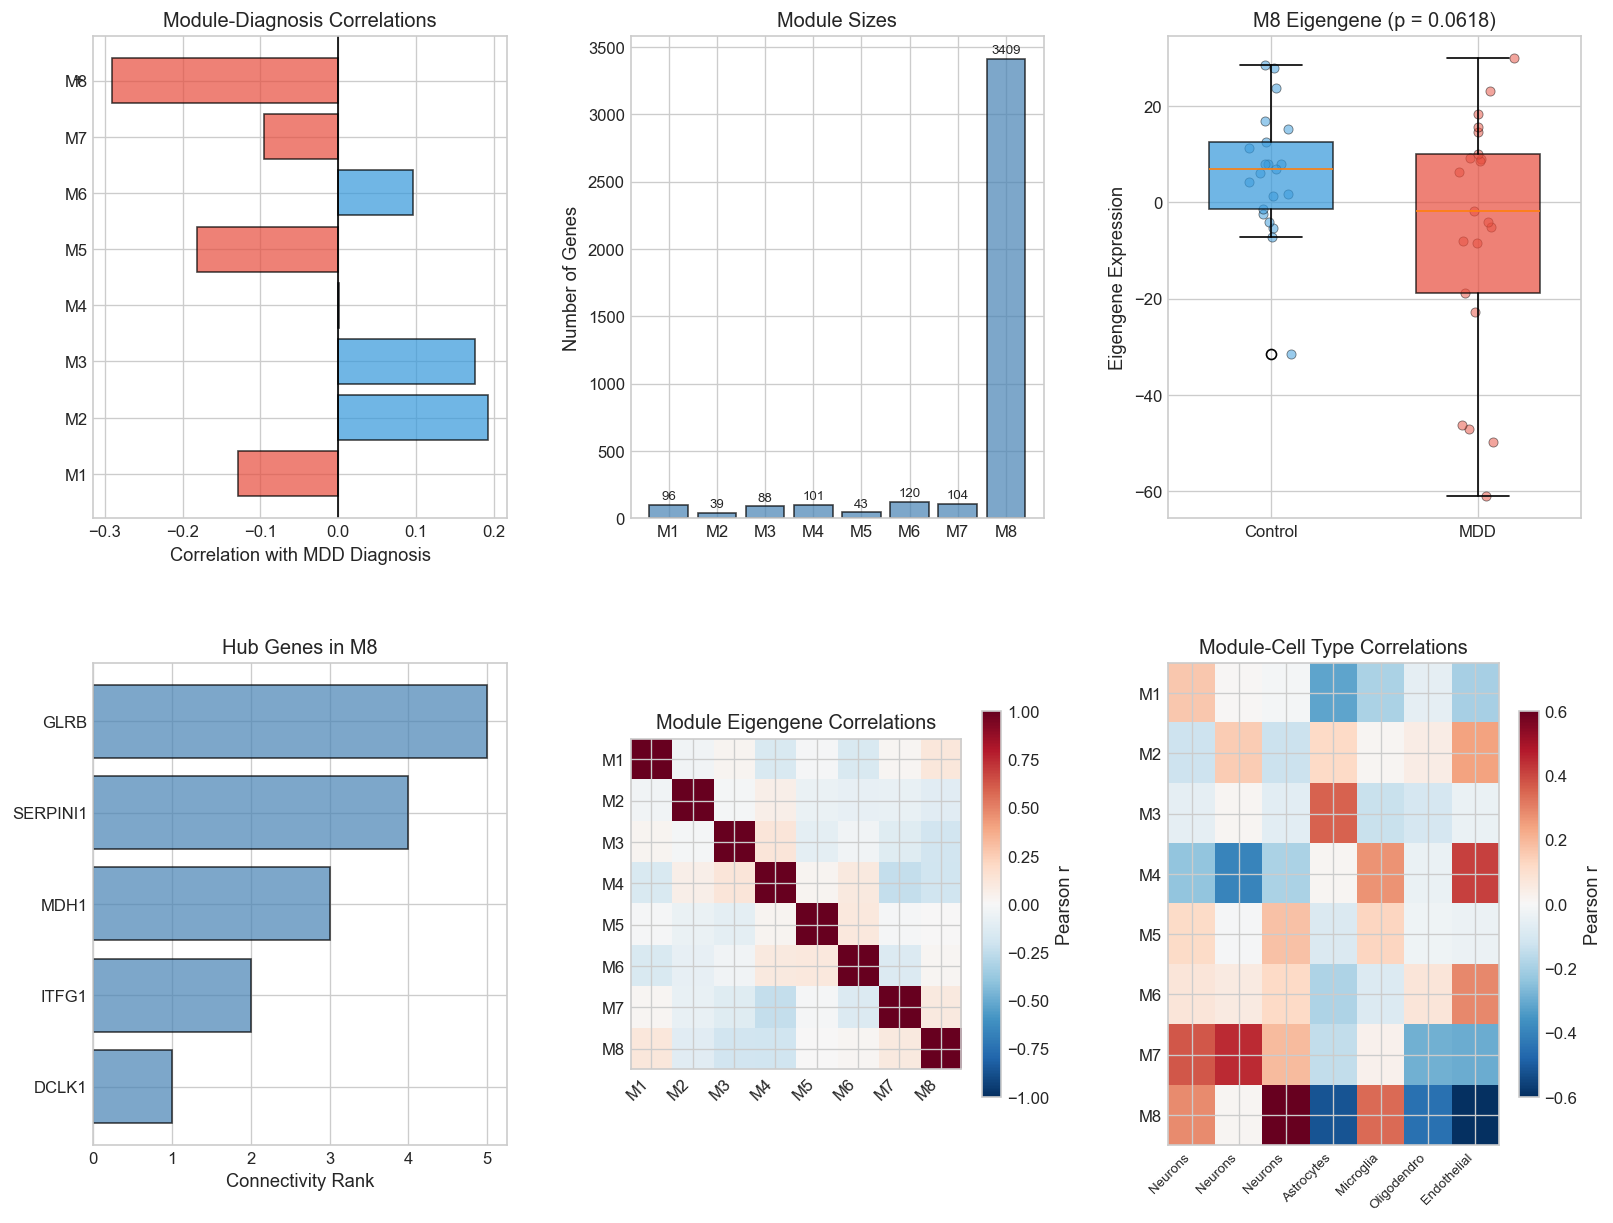

In [19]:
fig3 = plt.figure(figsize=(16, 12))
gs3 = gridspec.GridSpec(2, 3, figure=fig3, hspace=0.3, wspace=0.3)

mod_names = list(modules.keys())
n_mods = len(mod_names)

# Panel A: Module-diagnosis correlations
ax3a = fig3.add_subplot(gs3[0, 0])
corrs_net = module_traits_df['correlation'].values
pvals_net = module_traits_df['p_value'].values
colors_net = ['#e74c3c' if c < 0 else '#3498db' for c in corrs_net]

ax3a.barh(range(n_mods), corrs_net, color=colors_net, alpha=0.7, edgecolor='black')
ax3a.axvline(0, color='black', linewidth=1)

for i, (c, p) in enumerate(zip(corrs_net, pvals_net)):
    if p < 0.01:
        ax3a.text(c + 0.02 if c > 0 else c - 0.05, i, '**', va='center', fontsize=10)
    elif p < 0.05:
        ax3a.text(c + 0.02 if c > 0 else c - 0.05, i, '*', va='center', fontsize=10)
    elif p < 0.1:
        ax3a.text(c + 0.02 if c > 0 else c - 0.05, i, '+', va='center', fontsize=10)

ax3a.set_yticks(range(n_mods))
ax3a.set_yticklabels(mod_names)
ax3a.set_xlabel('Correlation with MDD Diagnosis')
ax3a.set_title('Module-Diagnosis Correlations')

# Panel B: Module sizes
ax3b = fig3.add_subplot(gs3[0, 1])
sizes_net = [modules[m]['size'] for m in mod_names]

bars = ax3b.bar(range(n_mods), sizes_net, color='steelblue', alpha=0.7, edgecolor='black')
ax3b.set_xticks(range(n_mods))
ax3b.set_xticklabels(mod_names)
ax3b.set_ylabel('Number of Genes')
ax3b.set_title('Module Sizes')

for i, (bar, size) in enumerate(zip(bars, sizes_net)):
    ax3b.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             str(size), ha='center', va='bottom', fontsize=8)

# Panel C: Most significant module eigengene
ax3c = fig3.add_subplot(gs3[0, 2])
best_mod_idx = np.argmin(pvals_net)
best_mod = mod_names[best_mod_idx]
eg_best = eigengenes[:, best_mod_idx]

bp3c = ax3c.boxplot([eg_best[y == 0], eg_best[y == 1]], patch_artist=True, widths=0.6)
bp3c['boxes'][0].set_facecolor('#3498db')
bp3c['boxes'][1].set_facecolor('#e74c3c')
for box in bp3c['boxes']:
    box.set_alpha(0.7)

ax3c.scatter(np.ones(sum(y==0)) + np.random.normal(0, 0.05, sum(y==0)), eg_best[y==0],
            alpha=0.5, color='#3498db', s=30, edgecolors='black', linewidth=0.5)
ax3c.scatter(np.ones(sum(y==1))*2 + np.random.normal(0, 0.05, sum(y==1)), eg_best[y==1],
            alpha=0.5, color='#e74c3c', s=30, edgecolors='black', linewidth=0.5)

ax3c.set_xticklabels(['Control', 'MDD'])
ax3c.set_ylabel('Eigengene Expression')
ax3c.set_title(f'{best_mod} Eigengene (p = {pvals_net[best_mod_idx]:.4f})')

# Panel D: Hub genes for most significant module
ax3d = fig3.add_subplot(gs3[1, 0])
hubs_best = modules[best_mod]['hubs']

ax3d.barh(range(len(hubs_best)), range(len(hubs_best), 0, -1), color='steelblue',
         alpha=0.7, edgecolor='black')
ax3d.set_yticks(range(len(hubs_best)))
ax3d.set_yticklabels(hubs_best)
ax3d.set_xlabel('Connectivity Rank')
ax3d.set_title(f'Hub Genes in {best_mod}')
ax3d.invert_yaxis()

# Panel E: Module eigengene correlation matrix
ax3e = fig3.add_subplot(gs3[1, 1])
eigen_df = pd.DataFrame(eigengenes, columns=mod_names)
eigen_corr = eigen_df.corr()

im3e = ax3e.imshow(eigen_corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax3e.set_xticks(range(n_mods))
ax3e.set_xticklabels(mod_names, rotation=45, ha='right')
ax3e.set_yticks(range(n_mods))
ax3e.set_yticklabels(mod_names)
ax3e.set_title('Module Eigengene Correlations')
plt.colorbar(im3e, ax=ax3e, shrink=0.8, label='Pearson r')

# Panel F: Module-cell type correlations
ax3f = fig3.add_subplot(gs3[1, 2])
mod_ct_corr = np.zeros((n_mods, len(ct_names)))

for i in range(n_mods):
    for j, ct in enumerate(ct_names):
        r, _ = stats.pearsonr(eigengenes[:, i], celltype_df[ct].values)
        mod_ct_corr[i, j] = r

im3f = ax3f.imshow(mod_ct_corr, cmap='RdBu_r', vmin=-0.6, vmax=0.6, aspect='auto')
ax3f.set_xticks(range(len(ct_names)))
ax3f.set_xticklabels([ct.split('_')[0] for ct in ct_names], rotation=45, ha='right', fontsize=8)
ax3f.set_yticks(range(n_mods))
ax3f.set_yticklabels(mod_names)
ax3f.set_title('Module-Cell Type Correlations')
plt.colorbar(im3f, ax=ax3f, shrink=0.8, label='Pearson r')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'Figure3_Network.png'), dpi=300, bbox_inches='tight')
plt.show()

Computing t-SNE...


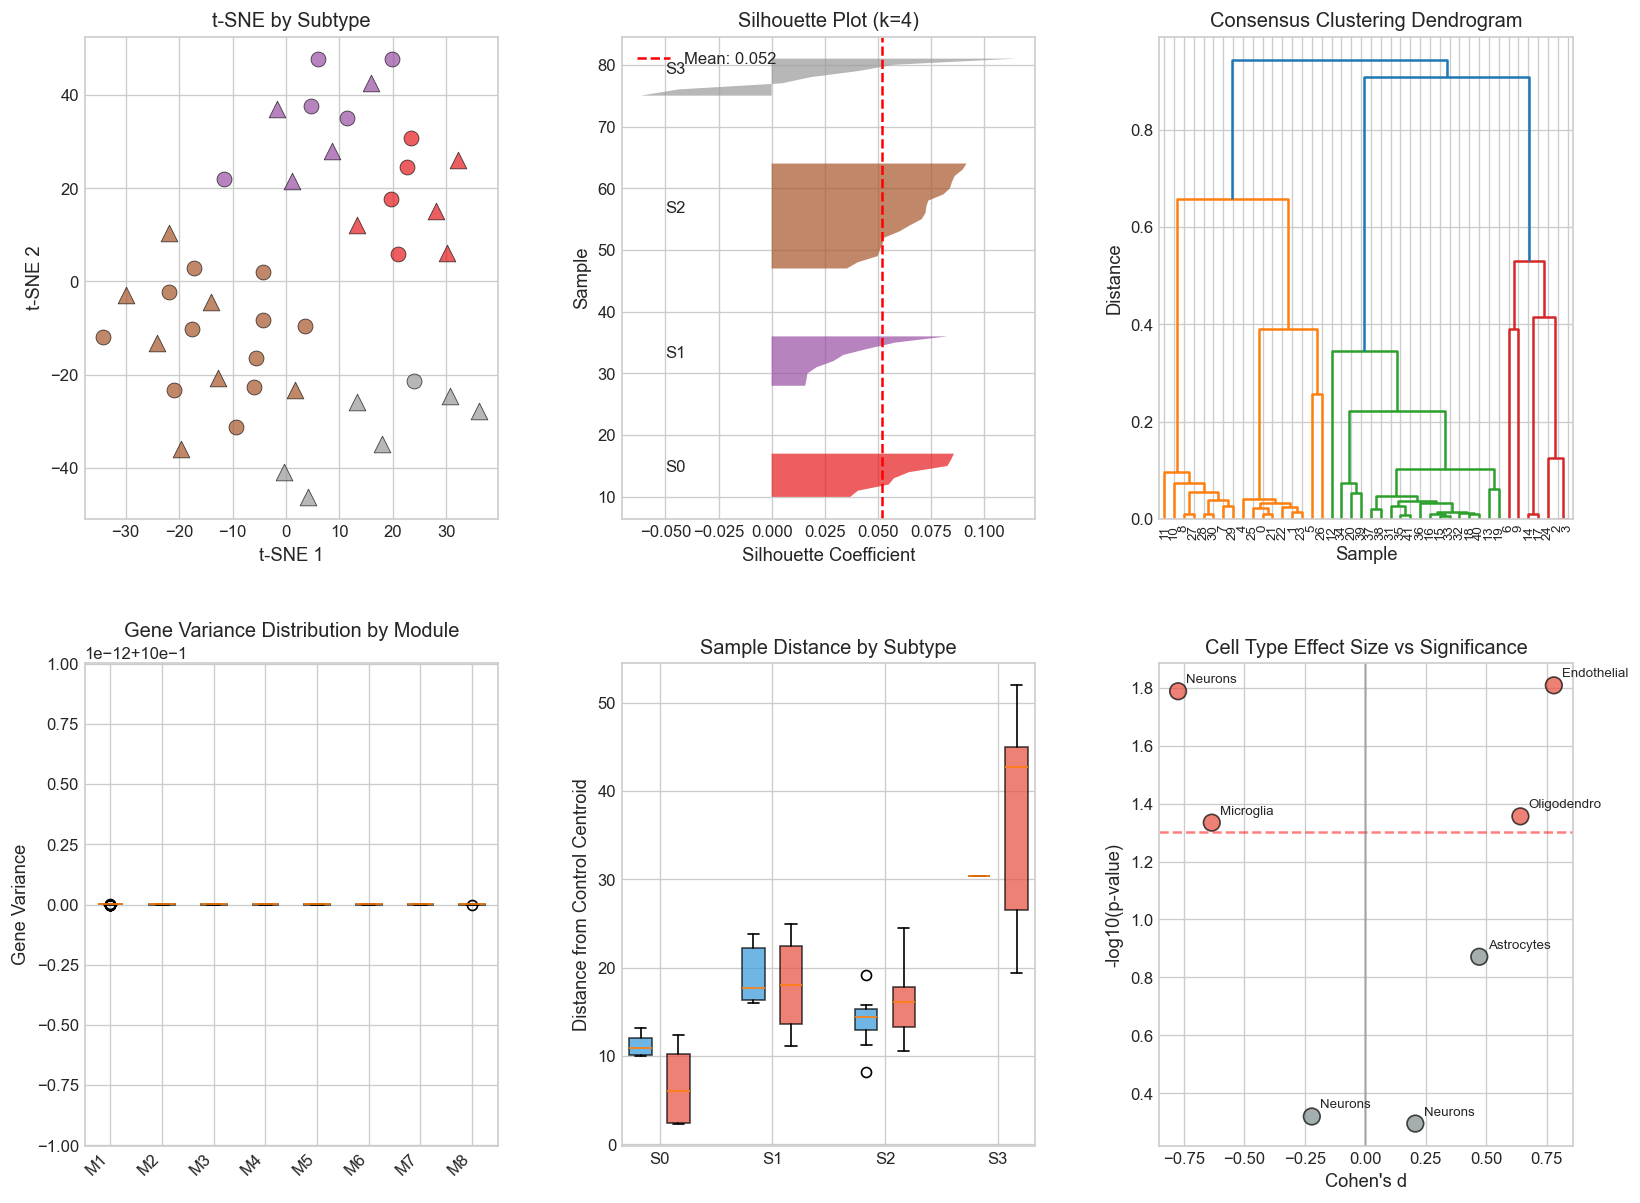

In [14]:
fig4 = plt.figure(figsize=(16, 12))
gs4 = gridspec.GridSpec(2, 3, figure=fig4, hspace=0.3, wspace=0.3)

# Panel A: t-SNE visualization
ax4a = fig4.add_subplot(gs4[0, 0])
print("Computing t-SNE...")
tsne = TSNE(n_components=2, perplexity=10, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X[:, np.argsort(np.var(X, axis=0))[-2000:]])

for s in range(optimal_k):
    mask = subtype_labels == s
    ax4a.scatter(X_tsne[mask & (y==0), 0], X_tsne[mask & (y==0), 1],
                c=[colors_sub[s]], marker='o', s=80, alpha=0.7,
                edgecolors='black', linewidth=0.5)
    ax4a.scatter(X_tsne[mask & (y==1), 0], X_tsne[mask & (y==1), 1],
                c=[colors_sub[s]], marker='^', s=100, alpha=0.7,
                edgecolors='black', linewidth=0.5)

ax4a.set_xlabel('t-SNE 1')
ax4a.set_ylabel('t-SNE 2')
ax4a.set_title('t-SNE by Subtype')

# Panel B: Silhouette plot for optimal k
ax4b = fig4.add_subplot(gs4[0, 1])
sil_samples = consensus_results[optimal_k]['silhouette_samples']
y_lower = 10

for cluster in range(optimal_k):
    cluster_sils = sil_samples[subtype_labels == cluster]
    cluster_sils.sort()
    size = len(cluster_sils)
    y_upper = y_lower + size
    
    ax4b.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sils,
                      facecolor=colors_sub[cluster], alpha=0.7)
    ax4b.text(-0.05, y_lower + 0.5 * size, f'S{cluster}')
    y_lower = y_upper + 10

ax4b.axvline(consensus_results[optimal_k]['silhouette'], color='red',
            linestyle='--', label=f'Mean: {consensus_results[optimal_k]["silhouette"]:.3f}')
ax4b.set_xlabel('Silhouette Coefficient')
ax4b.set_ylabel('Sample')
ax4b.set_title(f'Silhouette Plot (k={optimal_k})')
ax4b.legend()

# Panel C: Dendrogram for consensus clustering
ax4c = fig4.add_subplot(gs4[0, 2])
Z_opt = consensus_results[optimal_k]['linkage']
dendrogram(Z_opt, ax=ax4c, leaf_rotation=90, leaf_font_size=8,
          color_threshold=0.7*max(Z_opt[:,2]))
ax4c.set_xlabel('Sample')
ax4c.set_ylabel('Distance')
ax4c.set_title('Consensus Clustering Dendrogram')

# Panel D: Gene variance by module
ax4d = fig4.add_subplot(gs4[1, 0])

# Define module names first
mod_names = list(modules.keys())

module_vars = []
for name, info in modules.items():
    gene_idx = [gene_names.index(g) for g in info['genes'] if g in gene_names]
    if gene_idx:
        vars_mod = np.var(X[:, gene_idx], axis=0)
        module_vars.append(vars_mod)

bp4d = ax4d.boxplot(module_vars, patch_artist=True)
for i, patch in enumerate(bp4d['boxes']):
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)

ax4d.set_xticklabels(mod_names, rotation=45, ha='right')  # Added rotation for readability
ax4d.set_ylabel('Gene Variance')
ax4d.set_title('Gene Variance Distribution by Module')


# Panel E: Sample distance from control centroid
ax4e = fig4.add_subplot(gs4[1, 1])
ctrl_center = np.mean(X_pca[y == 0], axis=0)
distances = np.linalg.norm(X_pca - ctrl_center, axis=1)

for s in range(optimal_k):
    mask = subtype_labels == s
    ctrl_dist = distances[mask & (y == 0)]
    mdd_dist = distances[mask & (y == 1)]
    
    positions = [s*3, s*3 + 1]
    bp = ax4e.boxplot([ctrl_dist, mdd_dist], positions=positions, widths=0.6, patch_artist=True)
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#e74c3c')
    for box in bp['boxes']:
        box.set_alpha(0.7)

ax4e.set_xticks([s*3 + 0.5 for s in range(optimal_k)])
ax4e.set_xticklabels([f'S{s}' for s in range(optimal_k)])
ax4e.set_ylabel('Distance from Control Centroid')
ax4e.set_title('Sample Distance by Subtype')

# Panel F: Volcano-style plot for cell types
ax4f = fig4.add_subplot(gs4[1, 2])
effect_sizes_ct = [r['cohens_d'] for r in celltype_results]
pvals_ct = [r['p_value'] for r in celltype_results]
neg_log_p = [-np.log10(p) for p in pvals_ct]

colors_vol = ['#e74c3c' if p < 0.05 else '#7f8c8d' for p in pvals_ct]
ax4f.scatter(effect_sizes_ct, neg_log_p, c=colors_vol, s=100, alpha=0.7, edgecolors='black')

for i, ct in enumerate(ct_names):
    ax4f.annotate(ct.split('_')[0], (effect_sizes_ct[i], neg_log_p[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4f.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
ax4f.axvline(0, color='gray', linestyle='-', alpha=0.5)
ax4f.set_xlabel("Cohen's d")
ax4f.set_ylabel('-log10(p-value)')
ax4f.set_title('Cell Type Effect Size vs Significance')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'Figure4_Supplementary.png'), dpi=300, bbox_inches='tight')
plt.show()

In [15]:
print("="*60)
print("EXPORTING GENE LISTS FOR PATHWAY ENRICHMENT")
print("="*60)

for name, info in modules.items():
    filename = os.path.join(OUT_DIR, f'{name}_genes.txt')
    with open(filename, 'w') as f:
        f.write('\n'.join(info['genes']))
    print(f"  {name}_genes.txt: {info['size']} genes")

# Export hub genes
all_hubs = []
for name, info in modules.items():
    all_hubs.extend(info['hubs'])

hub_filename = os.path.join(OUT_DIR, 'all_hub_genes.txt')
with open(hub_filename, 'w') as f:
    f.write('\n'.join(all_hubs))
print(f"  all_hub_genes.txt: {len(all_hubs)} genes")

EXPORTING GENE LISTS FOR PATHWAY ENRICHMENT
  M1_genes.txt: 96 genes
  M2_genes.txt: 39 genes
  M3_genes.txt: 88 genes
  M4_genes.txt: 101 genes
  M5_genes.txt: 43 genes
  M6_genes.txt: 120 genes
  M7_genes.txt: 104 genes
  M8_genes.txt: 3409 genes
  all_hub_genes.txt: 40 genes


In [16]:
print("="*70)
print("ANALYSIS SUMMARY")
print("="*70)

print("\n1. DATA OVERVIEW")
print("-" * 40)
print(f"   Total samples: {X.shape[0]}")
print(f"   MDD cases: {sum(y==1)}")
print(f"   Controls: {sum(y==0)}")
print(f"   Total genes: {X.shape[1]:,}")

print("\n2. CONSENSUS CLUSTERING")
print("-" * 40)
print(f"   Optimal k: {optimal_k}")
print(f"   Cophenetic correlation: {consensus_results[optimal_k]['cophenetic']:.3f}")
print(f"   PAC score: {consensus_results[optimal_k]['pac']:.3f}")
print(f"   Silhouette score: {consensus_results[optimal_k]['silhouette']:.3f}")
print(f"   Chi-square (subtype vs diagnosis): {chi2:.3f} (p = {p_subtype:.4f})")
print(f"   Adjusted Rand Index: {ari:.3f}")

print("\n3. CELL-TYPE DECONVOLUTION")
print("-" * 40)
print(f"   Cell types analyzed: {len(celltype_df.columns)}")
print(f"   Significant (p < 0.05): {sum(r['p_value'] < 0.05 for r in celltype_results)}")
print("   Top findings:")
sorted_ct = sorted(celltype_results, key=lambda x: x['p_value'])
for r in sorted_ct[:4]:
    direction = 'increased' if r['cohens_d'] > 0 else 'decreased'
    print(f"     {r['cell_type']}: d = {r['cohens_d']:.2f} ({direction}), p = {r['p_value']:.4f}")

print("\n4. NETWORK ANALYSIS")
print("-" * 40)
print(f"   Genes in network: {n_genes_net}")
print(f"   Modules identified: {len(modules)}")
print(f"   Soft threshold power: {soft_power}")
n_sig_mods = sum(module_traits_df['p_value'] < 0.05)
print(f"   Diagnosis-associated (p < 0.05): {n_sig_mods}")
print(f"   Most significant module: {best_mod}")
print(f"     Correlation: {corrs_net[best_mod_idx]:.3f}")
print(f"     P-value: {pvals_net[best_mod_idx]:.4f}")
print(f"     Size: {modules[best_mod]['size']} genes")
print(f"     Hub genes: {', '.join(modules[best_mod]['hubs'])}")

ANALYSIS SUMMARY

1. DATA OVERVIEW
----------------------------------------
   Total samples: 42
   MDD cases: 21
   Controls: 21
   Total genes: 36,157

2. CONSENSUS CLUSTERING
----------------------------------------
   Optimal k: 4
   Cophenetic correlation: 0.968
   PAC score: 0.336
   Silhouette score: 0.052
   Chi-square (subtype vs diagnosis): 4.571 (p = 0.2060)
   Adjusted Rand Index: 0.014

3. CELL-TYPE DECONVOLUTION
----------------------------------------
   Cell types analyzed: 7
   Significant (p < 0.05): 4
   Top findings:
     Endothelial: d = 0.78 (increased), p = 0.0156
     Neurons_Inhib: d = -0.77 (decreased), p = 0.0163
     Oligodendro: d = 0.64 (increased), p = 0.0441
     Microglia: d = -0.63 (decreased), p = 0.0463

4. NETWORK ANALYSIS
----------------------------------------
   Genes in network: 4000
   Modules identified: 8
   Soft threshold power: 6
   Diagnosis-associated (p < 0.05): 0
   Most significant module: M8
     Correlation: -0.291
     P-value: 0.0

In [17]:
print("Exporting results tables...")

# Subtype information
subtype_df.to_csv(os.path.join(OUT_DIR, 'Table_Subtypes.csv'), index=False)
print("  Saved: Table_Subtypes.csv")

# Cell type results
celltype_results_df.to_csv(os.path.join(OUT_DIR, 'Table_CellTypes.csv'), index=False)
print("  Saved: Table_CellTypes.csv")

# Module traits
module_traits_df.to_csv(os.path.join(OUT_DIR, 'Table_Modules.csv'), index=False)
print("  Saved: Table_Modules.csv")

# Clustering metrics
clustering_metrics = []
for k, r in consensus_results.items():
    clustering_metrics.append({
        'k': k,
        'cophenetic': r['cophenetic'],
        'silhouette': r['silhouette'],
        'pac': r['pac']
    })
pd.DataFrame(clustering_metrics).to_csv(os.path.join(OUT_DIR, 'Table_ClusteringMetrics.csv'), index=False)
print("  Saved: Table_ClusteringMetrics.csv")

print(f"\nAll tables exported to: {OUT_DIR}")

Exporting results tables...
  Saved: Table_Subtypes.csv
  Saved: Table_CellTypes.csv
  Saved: Table_Modules.csv
  Saved: Table_ClusteringMetrics.csv

All tables exported to: output/Phase_3
